# Best LB kernel

copy from https://www.kaggle.com/karkun/sergey-ivanov-msu-mmp

Used in this kernel:¶
1. preprocessed dataset by olivier https://www.kaggle.com/ogrellier/create-extracted-json-fields-dataset
2. exported google analytics data https://www.kaggle.com/satian/exported-google-analytics-data
3. story of a leak v.01 https://www.kaggle.com/igauty/story-of-a-leak-v01
4. future is here https://www.kaggle.com/ashishpatel26/future-is-here
5. teach-lightgbm-to-sum-predictions https://www.kaggle.com/satian/story-of-a-leak/notebook
6. The code below is full of bugs, which I didn't remove as they seem to improve LB.

# load and concate

In [1]:
import pandas as pd
import numpy as np

# DRAGONS
import xgboost as xgb
import lightgbm as lgb
# import catboost as cat

# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas / plt options
pd.options.display.max_columns = 999
plt.rcParams['figure.figsize'] = (14, 7)
font = {'family' : 'verdana',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# remove warnings
import warnings
warnings.simplefilter("ignore")

# garbage collector
import gc
gc.enable()

In [2]:
from downcast import save_dataframe, load_dataframe

In [3]:
train = load_dataframe("./data/extracted_fields_train")
test = load_dataframe("./data/extracted_fields_test")
train.shape, test.shape

((903653, 30), (804684, 30))

In [4]:
dtypes = {'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64, 'visitStartTime': np.int64}

for k, v in dtypes.items():
    train[k] = train[k].astype(v)
    test[k] = test[k].astype(v)

In [5]:
train.head().T

,0,1,2,3,4
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
date,20160902,20160902,20160902,20160902,20160902
fullVisitorId,1131660440785968503,377306020877927890,3895546263509774583,4763447161404445595,27294437909732085
sessionId,1131660440785968503_1472830385,377306020877927890_1472880147,3895546263509774583_1472865386,4763447161404445595_1472881213,27294437909732085_1472822600
visitId,1472830385,1472880147,1472865386,1472881213,1472822600
visitNumber,1,1,1,1,2
visitStartTime,1472830385,1472880147,1472865386,1472881213,1472822600
device.browser,Chrome,Firefox,Chrome,UC Browser,Chrome
device.deviceCategory,desktop,desktop,desktop,desktop,mobile
device.isMobile,0,0,0,0,1


In [6]:
# Getting data from leak
train_store_1 = pd.read_csv('./data/exported-google-analytics-data/Train_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
train_store_2 = pd.read_csv('./data/exported-google-analytics-data/Train_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_1 = pd.read_csv('./data/exported-google-analytics-data/Test_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_2 = pd.read_csv('./data/exported-google-analytics-data/Test_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})

# Getting VisitId from Google Analytics...
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(np.int64)

In [7]:
# Merge with train/test data
train = train.merge(pd.concat([train_store_1, train_store_2], sort=False), how="left", on="visitId")
test = test.merge(pd.concat([test_store_1, test_store_2], sort=False), how="left", on="visitId")

In [8]:
# Drop Client Id
for df in [train, test]:
    df.drop("Client Id", 1, inplace=True)

In [9]:
train.head().T

,0,1,2,3,4
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
date,20160902,20160902,20160902,20160902,20160902
fullVisitorId,1131660440785968503,377306020877927890,3895546263509774583,4763447161404445595,27294437909732085
sessionId,1131660440785968503_1472830385,377306020877927890_1472880147,3895546263509774583_1472865386,4763447161404445595_1472881213,27294437909732085_1472822600
visitId,1472830385,1472880147,1472865386,1472881213,1472822600
visitNumber,1,1,1,1,2
visitStartTime,1472830385,1472880147,1472865386,1472881213,1472822600
device.browser,Chrome,Firefox,Chrome,UC Browser,Chrome
device.deviceCategory,desktop,desktop,desktop,desktop,mobile
device.isMobile,0,0,0,0,1


# preprocessing reventue

In [10]:
# Cleaning Revenue
for df in [train, test]:
    df["Revenue"].fillna('$', inplace=True)
    df["Revenue"] = df["Revenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    df["Revenue"].fillna(0.0, inplace=True)

In [11]:
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    del df
gc.collect()

49

# looking around

In [12]:
target_sums = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

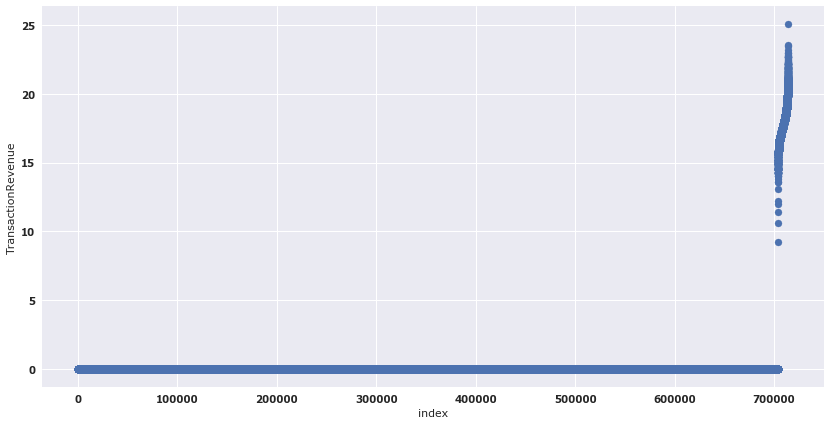

In [13]:
plt.scatter(range(target_sums.shape[0]), np.sort(np.log1p(target_sums["totals.transactionRevenue"].values)))
plt.xlabel('index')
plt.ylabel('TransactionRevenue')
plt.show()

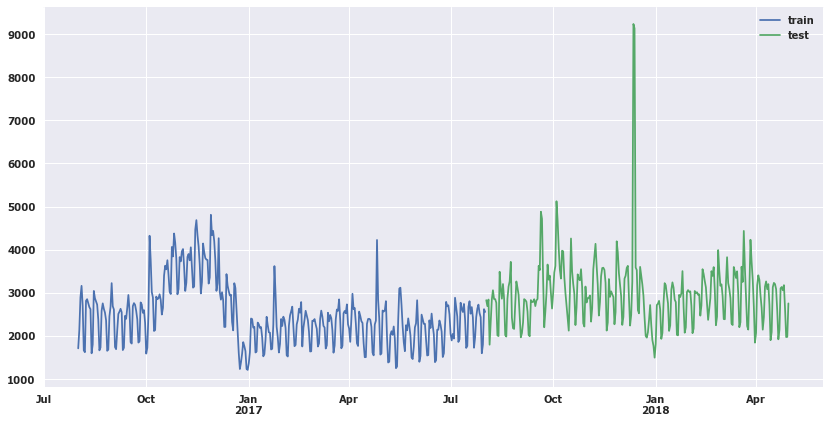

In [14]:
train.date = pd.to_datetime(train.date, format="%Y%m%d")
test.date = pd.to_datetime(test.date, format="%Y%m%d")
train.date.value_counts().sort_index().plot(label="train")
test.date.value_counts().sort_index().plot(label="test")
plt.legend()

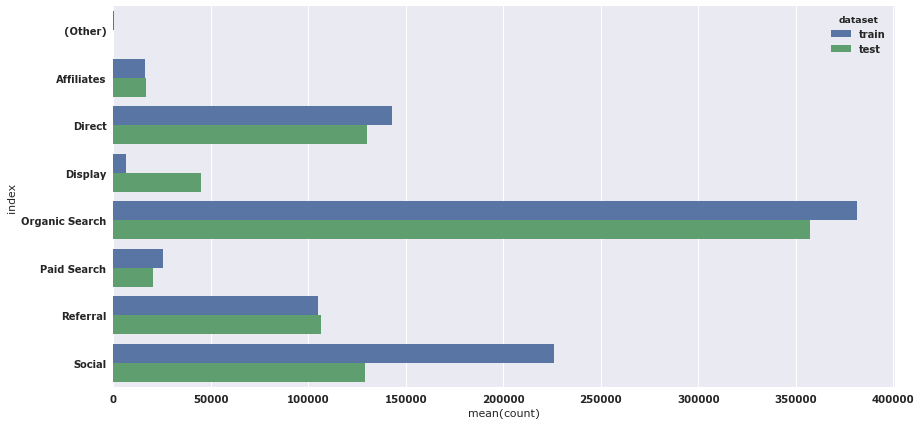

In [15]:
def drawBars(columnname):
    sns.barplot(x="count", y="index", hue="dataset",
        data=pd.melt(pd.concat([train[columnname].value_counts().rename("train"), 
                       test[columnname].value_counts().rename("test")], axis=1, sort="False").reset_index(),
            id_vars="index", var_name="dataset", value_name="count"))

drawBars("channelGrouping")

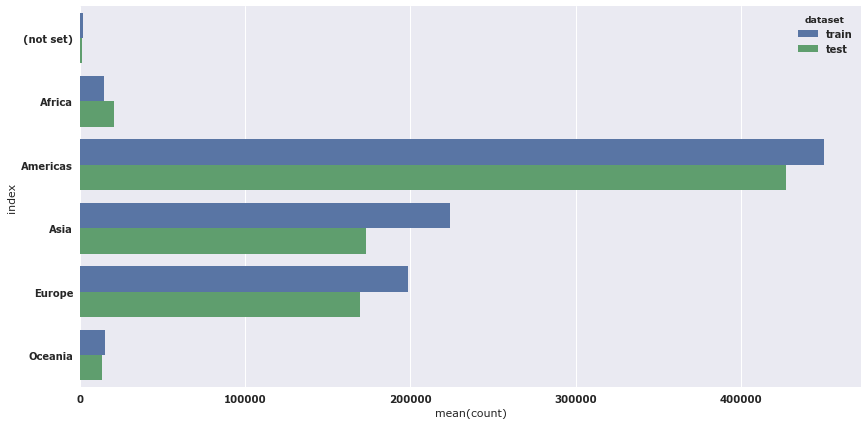

In [16]:
drawBars("geoNetwork.continent")

In [17]:
ids_train = set(train.fullVisitorId.unique())
ids_test = set(test.fullVisitorId.unique())
print("Unique visitor ids in train:", len(ids_train))
print("Unique visitor ids in test:", len(ids_test))
print("Common visitors in train and test:", len(ids_train & ids_test))

Unique visitor ids in train: 714167
Unique visitor ids in test: 617242
Common visitors in train and test: 7679


In [18]:
## duplicates?

In [19]:
problem = train[train.sessionId.map(train.sessionId.value_counts() == 2)].sort_values(["sessionId", 'visitStartTime'])
problem.head(10)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
212027,Organic Search,2016-08-21,0011338928267756760,0011338928267756760_1471848731,1471848731,1,1471848731,Chrome,desktop,0,Windows,not available in demo dataset,Asia,China,not available in demo dataset,unknown.unknown,not available in demo dataset,Eastern Asia,NaN,2,1,1,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
82177,Organic Search,2016-08-22,0011338928267756760,0011338928267756760_1471848731,1471848731,1,1471849330,Chrome,desktop,0,Windows,not available in demo dataset,Asia,China,not available in demo dataset,unknown.unknown,not available in demo dataset,Eastern Asia,NaN,2,1,1,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
848580,Referral,2016-12-31,0014884852016449602,0014884852016449602_1483257533,1483257533,2,1483257533,Chrome,desktop,0,Macintosh,Los Angeles,Americas,United States,Los Angeles CA,(not set),California,Northern America,1,1,NaN,1,NaN,NaN,(not set),1,NaN,referral,/,mall.googleplex.com,NaN,NaN,NaN,0.0,NaN,NaN
802550,Referral,2017-01-01,0014884852016449602,0014884852016449602_1483257533,1483257533,2,1483257729,Chrome,desktop,0,Macintosh,Los Angeles,Americas,United States,Los Angeles CA,(not set),California,Northern America,NaN,10,NaN,6,NaN,NaN,(not set),1,NaN,referral,/,mall.googleplex.com,NaN,NaN,NaN,0.0,NaN,NaN
428608,Organic Search,2017-06-05,0019612470994343873,0019612470994343873_1496731675,1496731675,24,1496731675,Chrome,desktop,0,Macintosh,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,comcast.net,California,Northern America,NaN,14,NaN,14,NaN,NaN,(not set),1,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
202288,Organic Search,2017-06-06,0019612470994343873,0019612470994343873_1496731675,1496731675,24,1496732439,Chrome,desktop,0,Macintosh,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,comcast.net,California,Northern America,NaN,2,NaN,2,NaN,NaN,(not set),1,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
46654,Paid Search,2017-05-19,0031542961723593073,0031542961723593073_1495261490,1495261490,1,1495261490,Chrome,tablet,1,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,comcast.net,not available in demo dataset,Northern America,NaN,37,1,32,NaN,{KeyWord:Google Brand Items},AW - Accessories,NaN,+google +tshirt +store,cpc,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
857847,Paid Search,2017-05-20,0031542961723593073,0031542961723593073_1495261490,1495261490,1,1495264358,Chrome,tablet,1,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,comcast.net,not available in demo dataset,Northern America,NaN,5,1,4,NaN,{KeyWord:Google Brand Items},AW - Accessories,NaN,+google +tshirt +store,cpc,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
618668,Referral,2017-01-24,0039798900163330977,0039798900163330977_1485331011,1485331011,4,1485331011,Chrome,desktop,0,Macintosh,(not set),Asia,Singapore,(not set),(not set),(not set),Southeast Asia,NaN,5,NaN,5,NaN,NaN,(not set),1,NaN,referral,/,mall.googleplex.com,NaN,NaN,NaN,0.0,NaN,NaN
520543,Referral,2017-01-25,0039798900163330977,0039798900163330977_1485331011,1485331011,4,1485331307,Chrome,desktop,0,Macintosh,(not set),Asia,Singapore,(not set),(not set),(not set),Southeast Asia,NaN,5,NaN,3,NaN,NaN,(not set),1,NaN,referral,/,mall.googleplex.com,NaN,NaN,NaN,0.0,NaN,NaN


In [20]:
(train.visitStartTime == train.visitId).value_counts()

True     898945
False      4709
dtype: int64

In [21]:
train[(train.visitStartTime == train.visitId)].head().T

,0,1,2,3,4
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
date,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00
fullVisitorId,1131660440785968503,377306020877927890,3895546263509774583,4763447161404445595,27294437909732085
sessionId,1131660440785968503_1472830385,377306020877927890_1472880147,3895546263509774583_1472865386,4763447161404445595_1472881213,27294437909732085_1472822600
visitId,1472830385,1472880147,1472865386,1472881213,1472822600
visitNumber,1,1,1,1,2
visitStartTime,1472830385,1472880147,1472865386,1472881213,1472822600
device.browser,Chrome,Firefox,Chrome,UC Browser,Chrome
device.deviceCategory,desktop,desktop,desktop,desktop,mobile
device.isMobile,0,0,0,0,1


In [22]:
for df in [train, test]:
    df["isEqualId"] = (df.visitStartTime == df.visitId)

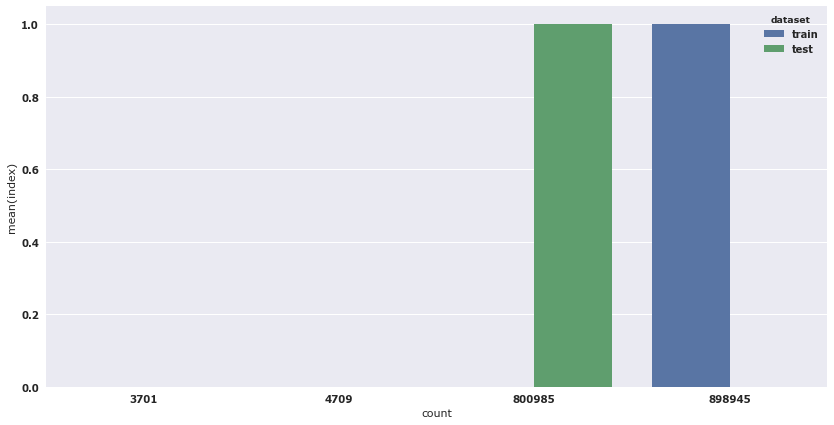

In [23]:
drawBars("isEqualId")

In [24]:
train.groupby("isEqualId").Revenue.mean()

isEqualId
False    0.332540
True     0.188405
Name: Revenue, dtype: float64

In [25]:
train.groupby("isEqualId").Revenue.std()

isEqualId
False    7.002370
True     5.056327
Name: Revenue, dtype: float64

In [26]:
train[(train.visitStartTime != train.visitId)].head().T

,332,607,869,957,1007
channelGrouping,Direct,Direct,Direct,Direct,Direct
date,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00
fullVisitorId,1985996754282674717,6535965121727665797,4132266413200674510,0382792108935137915,2801819956745270815
sessionId,1985996754282674717_1472839199,6535965121727665797_1472868357,4132266413200674510_1472840668,0382792108935137915_1472832679,2801819956745270815_1472840505
visitId,1472839199,1472868357,1472840668,1472832679,1472840505
visitNumber,1,1,1,1,1
visitStartTime,1472839203,1472868361,1472842358,1472832683,1472840508
device.browser,Safari,Safari,Chrome,Chrome,Chrome
device.deviceCategory,mobile,mobile,desktop,desktop,desktop
device.isMobile,1,1,0,0,0


# preprocessing start time

In [27]:
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [28]:
train.set_index("visitStartTime", inplace=True)
test.set_index("visitStartTime", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

# preprocessing categories

In [29]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [30]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [31]:
clearRare("device.browser")
clearRare("device.operatingSystem")
clearRare("geoNetwork.country")
clearRare("geoNetwork.city")
clearRare("geoNetwork.metro")
clearRare("geoNetwork.networkDomain")
clearRare("geoNetwork.region")
clearRare("geoNetwork.subContinent")
clearRare("trafficSource.adContent")
clearRare("trafficSource.campaign")
clearRare("trafficSource.keyword")
clearRare("trafficSource.medium")
clearRare("trafficSource.referralPath")
clearRare("trafficSource.source")

Set 98 device.browser categories to 'other'; now there are 11 categories in train
Set 15 device.operatingSystem categories to 'other'; now there are 8 categories in train
Set 160 geoNetwork.country categories to 'other'; now there are 60 categories in train
Set 656 geoNetwork.city categories to 'other'; now there are 77 categories in train
Set 86 geoNetwork.metro categories to 'other'; now there are 24 categories in train
Set 25689 geoNetwork.networkDomain categories to 'other'; now there are 62 categories in train
Set 314 geoNetwork.region categories to 'other'; now there are 62 categories in train
Set 5 geoNetwork.subContinent categories to 'other'; now there are 19 categories in train
Set 46 trafficSource.adContent categories to 'other'; now there are 4 categories in train
Set 23 trafficSource.campaign categories to 'other'; now there are 5 categories in train
Set 2409 trafficSource.keyword categories to 'other'; now there are 8 categories in train
Set 1 trafficSource.medium categor

In [32]:
# Clearing leaked data:
for df in [train, test]:
    df["Avg. Session Duration"][df["Avg. Session Duration"] == 0] = "00:00:00"
    df["Avg. Session Duration"] = df["Avg. Session Duration"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
    df["Bounce Rate"] = df["Bounce Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)
    df["Goal Conversion Rate"] = df["Goal Conversion Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

# features

In [33]:
# id features

for df in [train, test]:
    # remember these features were equal, but not always? May be it means something...
    df["id_incoherence"] = pd.to_datetime(df.visitId, unit='s') != df.date
    # remember visitId dublicates?
    df["visitId_dublicates"] = df.visitId.map(df.visitId.value_counts())
    # remember session dublicates?
    df["session_dublicates"] = df.sessionId.map(df.sessionId.value_counts())

In [34]:
# Basic time features

for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    #df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.date       # it must not be included in features during learning!

In [35]:
# Looking to future features (from https://www.kaggle.com/ashishpatel26/future-is-here):

df = pd.concat([train, test])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
df.sort_index(inplace=True)

train = df[:len(train)]
test = df[len(train):]

In [36]:
# Paired categories from "teach-lightgbm-to-sum-predictions" kernel

for df in [train, test]:
    df['source.country'] = df['trafficSource.source'] + '_' + df['geoNetwork.country']
    df['campaign.medium'] = df['trafficSource.campaign'] + '_' + df['trafficSource.medium']
    df['browser.category'] = df['device.browser'] + '_' + df['device.deviceCategory']
    df['browser.os'] = df['device.browser'] + '_' + df['device.operatingSystem']

In [37]:
for df in [train, test]:
    df['device_deviceCategory_channelGrouping'] = df['device.deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device.browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device.operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content.source'] = df['trafficSource.adContent'].astype(str) + "_" + df['source.country']
    df['medium.source'] = df['trafficSource.medium'] + "_" + df['source.country']

In [38]:
# User-aggregating features

for feature in ["totals.hits", "totals.pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)

for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

# encoding features

In [39]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day', 'help']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

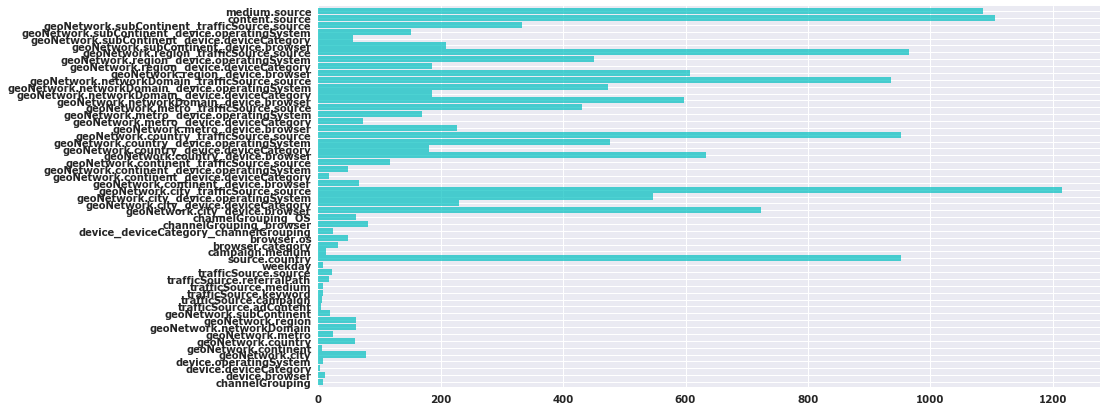

In [40]:
train[cat_cols].nunique().plot(kind="barh", color="c", alpha=.7, width=.9)

In [41]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [42]:
for col in real_cols:
    train[col] = train[col].astype(np.float32)
    test[col] = test[col].astype(np.float32)

In [43]:
train[real_cols + cat_cols].head().T

visitStartTime,2016-08-01 07:00:12,2016-08-01 07:04:26,2016-08-01 07:04:41,2016-08-01 07:06:01,2016-08-01 07:06:10
visitNumber,3.0,1.0,1.0,1.0,1.0
device.isMobile,1.0,0.0,1.0,0.0,0.0
totals.bounces,1.0,1.0,0.0,0.0,1.0
totals.hits,1.0,1.0,5.0,9.0,1.0
totals.newVisits,0.0,1.0,1.0,1.0,1.0
totals.pageviews,1.0,1.0,5.0,7.0,1.0
trafficSource.isTrueDirect,1.0,0.0,0.0,0.0,1.0
Sessions,0.0,0.0,0.0,0.0,0.0
Avg. Session Duration,0.0,0.0,0.0,0.0,0.0
Bounce Rate,0.0,0.0,0.0,0.0,0.0


In [44]:
for to_del in ["date", "sessionId", "visitId", "day"]:
    del train[to_del]
    del test[to_del]

# validation

In [45]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', "month", "help"]

cat_cols = [f for f in train.columns if (train[f].dtype == 'int64' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [46]:
from sklearn.metrics import mean_squared_error
def score(data, y):
    validation_res = pd.DataFrame(
    {"fullVisitorId": data["fullVisitorId"].values,
     "transactionRevenue": data["totals.transactionRevenue"].values,
     "predictedRevenue": np.expm1(y)})

    validation_res = validation_res.groupby("fullVisitorId")["transactionRevenue", "predictedRevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionRevenue"].values), 
                                     np.log1p(validation_res["predictedRevenue"].values)))

In [47]:
from sklearn.model_selection import GroupKFold

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['fullVisitorId'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["totals.transactionRevenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["totals.transactionRevenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [48]:
Kfolder = KFoldValidation(train)

In [49]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)

In [50]:
Kfolder.validate(train, test, real_cols + cat_cols, lgbmodel, "lgbpred", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.62638
[200]	valid_0's rmse: 1.59391
[300]	valid_0's rmse: 1.58501
[400]	valid_0's rmse: 1.58084
[500]	valid_0's rmse: 1.57896
[600]	valid_0's rmse: 1.57735
[700]	valid_0's rmse: 1.57625
[800]	valid_0's rmse: 1.57585
Early stopping, best iteration is:
[786]	valid_0's rmse: 1.57582
Fold  0  error:  1.5743433653682606
Fold  0  score:  1.5557321321653879
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.59857
[200]	valid_0's rmse: 1.57066
[300]	valid_0's rmse: 1.56273
[400]	valid_0's rmse: 1.55845
[500]	valid_0's rmse: 1.55613
[600]	valid_0's rmse: 1.55447
[700]	valid_0's rmse: 1.55381
[800]	valid_0's rmse: 1.55332
Early stopping, best iteration is:
[787]	valid_0's rmse: 1.55322
Fold  1  error:  1.5519406754624583
Fold  1  score:  1.5551219296143146
Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.61066


1.5503986226297626

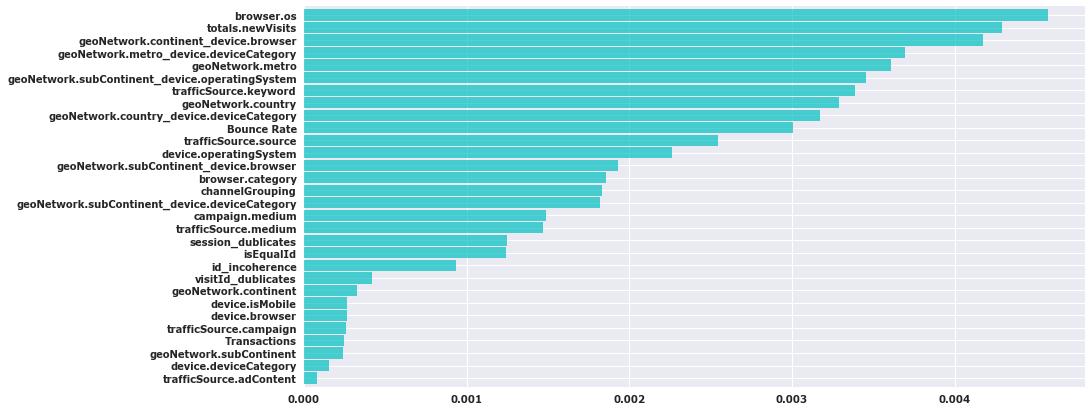

In [51]:
lgbmodel.FI.mean(axis=1).sort_values()[:30].plot(kind="barh", colors="c", alpha=.7, width=.9)

# user level

In [52]:
def create_user_df(df):
    agg_data = df[real_cols + cat_cols + ['fullVisitorId']].groupby('fullVisitorId').mean()
    
    pred_list = df[['fullVisitorId', 'lgbpred']].groupby('fullVisitorId').apply(lambda visitor_df: list(visitor_df.lgbpred))\
        .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
    all_predictions = pd.DataFrame(list(pred_list.values), index=agg_data.index)
    feats = all_predictions.columns

    all_predictions['t_mean'] = all_predictions.mean(axis=1)
    all_predictions['t_median'] = all_predictions.median(axis=1)   # including t_mean as one of the elements? well, ok
    all_predictions['t_sum_log'] = all_predictions.sum(axis=1)
    all_predictions['t_sum_act'] = all_predictions.fillna(0).sum(axis=1)
    all_predictions['t_nb_sess'] = all_predictions.isnull().sum(axis=1)

    full_data = pd.concat([agg_data, all_predictions], axis=1).astype(float)
    full_data['fullVisitorId'] = full_data.index
    del agg_data, all_predictions
    gc.collect()
    return full_data

In [53]:
user_train = create_user_df(train)
user_test = create_user_df(test)

In [54]:
train.shape, user_train.shape

((903654, 81), (714167, 362))

In [55]:
features = list(user_train.columns)[:-1]  # don't include "fullVisitorId"
user_train["totals.transactionRevenue"] = train[['fullVisitorId', 'totals.transactionRevenue']].groupby('fullVisitorId').sum()

In [56]:
for f in features:
    if f not in user_test.columns:
        user_test[f] = np.nan

# meta models

In [57]:
Kfolder = KFoldValidation(user_train)

In [58]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9,
                            use_best_model=True)

In [59]:
Kfolder.validate(user_train, user_test, features, lgbmodel, name="lgbfinal", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50151
[200]	valid_0's rmse: 1.49601
Early stopping, best iteration is:
[169]	valid_0's rmse: 1.49572
Fold  0  error:  1.495575359398961
Fold  0  score:  1.495575359398961
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50842
[200]	valid_0's rmse: 1.50563
Early stopping, best iteration is:
[155]	valid_0's rmse: 1.50437
Fold  1  error:  1.5042798986263812
Fold  1  score:  1.5042798986263812
Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50635
[200]	valid_0's rmse: 1.50192
Early stopping, best iteration is:
[205]	valid_0's rmse: 1.50183
Fold  2  error:  1.5017217665662155
Fold  2  score:  1.5017217665662155
Fold  3 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.48402
[200]	valid_0's rmse: 1.47788
Early stopping, best iteration is:
[221]	valid_0's rmse: 1.4777

1.4976040860988493

In [60]:
xgbmodel = xgb.XGBRegressor(max_depth=22, learning_rate=0.02, n_estimators=1000, 
                            objective='reg:linear', gamma=1.45, seed=2019, silent=False,
                            subsample=0.67, colsample_bytree=0.054, colsample_bylevel=0.50,
                            verbose=50)

In [61]:
Kfolder.validate(user_train, user_test, features, xgbmodel, name="xgbfinal", prepare_stacking=True)

Fold  0 :
[0]	validation_0-rmse:2.09942
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.65873
[200]	validation_0-rmse:1.5572
[300]	validation_0-rmse:1.53337
[400]	validation_0-rmse:1.52661
[500]	validation_0-rmse:1.52608
Stopping. Best iteration:
[458]	validation_0-rmse:1.52549

Fold  0  error:  1.5256921578598257
Fold  0  score:  1.5256921578889722
Fold  1 :
[0]	validation_0-rmse:2.09645
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.64187
[200]	validation_0-rmse:1.5482
[300]	validation_0-rmse:1.53015
[400]	validation_0-rmse:1.52545
[500]	validation_0-rmse:1.52403
Stopping. Best iteration:
[493]	validation_0-rmse:1.52388

Fold  1  error:  1.5240727351960057
Fold  1  score:  1.5240727351735246
Fold  2 :
[0]	validation_0-rmse:2.11149
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.65905
[200]	validation_0-rmse:1.55731
[300]	validation_0-rmse:1.53397
[400]	val

1.5224375630060942

In [62]:
import catboost as cat

In [63]:
catmodel = cat.CatBoostRegressor(iterations=500, learning_rate=0.2, depth=5, random_seed=2019)

In [64]:
Kfolder.validate(user_train, user_test, features, catmodel, name="catfinal", prepare_stacking=True,
                 fit_params={"use_best_model": True, "verbose": 100})

Fold  0 :
0:	learn: 1.9250416	test: 1.9267836	best: 1.9267836 (0)	total: 379ms	remaining: 3m 9s
100:	learn: 1.4660264	test: 1.4970328	best: 1.4967716 (91)	total: 33.1s	remaining: 2m 10s
200:	learn: 1.4384410	test: 1.4971303	best: 1.4963158 (112)	total: 1m 6s	remaining: 1m 38s
300:	learn: 1.4130507	test: 1.5010919	best: 1.4963158 (112)	total: 1m 41s	remaining: 1m 6s
400:	learn: 1.3906404	test: 1.5048026	best: 1.4963158 (112)	total: 2m 15s	remaining: 33.5s
499:	learn: 1.3701184	test: 1.5072945	best: 1.4963158 (112)	total: 2m 51s	remaining: 0us

bestTest = 1.496315807
bestIteration = 112

Shrink model to first 113 iterations.
Fold  0  error:  1.4962642668899377
Fold  0  score:  1.4962642668899377
Fold  1 :
0:	learn: 1.9253915	test: 1.9314730	best: 1.9314730 (0)	total: 317ms	remaining: 2m 38s
100:	learn: 1.4631632	test: 1.5077568	best: 1.5054078 (41)	total: 32.1s	remaining: 2m 6s
200:	learn: 1.4348292	test: 1.5110300	best: 1.5054078 (41)	total: 1m 6s	remaining: 1m 38s
300:	learn: 1.4105953

1.498395430016744

# blending

In [65]:
user_train['PredictedLogRevenue'] = 0.4 * user_train["lgbfinal"] + \
                                    0.2 * user_train["xgbfinal"] + \
                                    0.4 * user_train["catfinal"]
score(user_train, user_train.PredictedLogRevenue)

1.4957760064425472

In [66]:
user_test['PredictedLogRevenue'] = 0.4 * user_test["lgbfinal"] +  0.4 * user_test["catfinal"] + 0.2 * user_test["xgbfinal"]
user_test[['PredictedLogRevenue']].to_csv('./submissions/000-submission.csv', index=True)

# blending more

In [67]:
meta_names = ["lgbfinal", "xgbfinal", "catfinal"]

for df in [user_train, user_test]:
    df["maxbld"] = df[meta_names].max(axis=1)
    df["minbld"] = df[meta_names].min(axis=1)
    df["medianbld"] = df[meta_names].median(axis=1)

In [68]:
from sklearn.linear_model import LinearRegression

In [69]:
class LRWrapper():
    def __init__(self):
        self.feature_importances_ = None
        self.intercept_ = []
    
    
    def fit(self, X, y, eval_set):
        self.model = LinearRegression()
        self.model.fit(X, y)
        self.feature_importances_ = np.array(self.model.coef_)
        self.intercept_.append(self.model.intercept_)
    
    def predict(self, X):
        return self.model.predict(X)

In [70]:
features_lvl1 = meta_names + ["maxbld", "minbld", "medianbld"]

In [71]:
lrmodel = LRWrapper()

Kfolder.validate(user_train, user_test, features_lvl1, lrmodel, name="lrstack", prepare_stacking=True,
                 fit_params={})

Fold  0 :
Fold  0  error:  1.493017134928127
Fold  0  score:  1.493017134928127
Fold  1 :
Fold  1  error:  1.5022920333859935
Fold  1  score:  1.5022920333859935
Fold  2 :
Fold  2  error:  1.5010565739374684
Fold  2  score:  1.5010565739374684
Fold  3 :
Fold  3  error:  1.4755033622849663
Fold  3  score:  1.4755033622849663
Fold  4 :
Fold  4  error:  1.5058739552277813
Fold  4  score:  1.5058739552277813
Final score:  1.4955486119528674


1.4955486119528674

In [72]:
lrmodel = LRWrapper()
features_lvl1 = meta_names + ["medianbld"]

Kfolder.validate(user_train, user_test, features_lvl1, lrmodel, name="lrstack", prepare_stacking=True,
                 fit_params={})

Fold  0 :
Fold  0  error:  1.4931809882583449
Fold  0  score:  1.4931809882583449
Fold  1 :
Fold  1  error:  1.5018828504664488
Fold  1  score:  1.5018828504664488
Fold  2 :
Fold  2  error:  1.5012807878699344
Fold  2  score:  1.5012807878699344
Fold  3 :
Fold  3  error:  1.4757771814902738
Fold  3  score:  1.4757771814902738
Fold  4 :
Fold  4  error:  1.5056893609207673
Fold  4  score:  1.5056893609207673
Final score:  1.495562233801154


1.495562233801154

In [73]:
lrmodel.FI

,fold0,fold1,fold2,fold3,fold4
lgbfinal,0.400365,0.323676,0.300356,0.306352,0.518089
xgbfinal,0.099249,0.046456,0.080350,0.092424,0.114671
catfinal,0.362599,0.296440,0.359163,0.263893,0.405607
medianbld,0.137787,0.333429,0.260131,0.337331,-0.038368


In [74]:
lrmodel = LRWrapper()
features_lvl1 = meta_names + ["medianbld"]

Kfolder.validate(user_train, user_test, meta_names, lrmodel, name="lrstack", prepare_stacking=True,
                 fit_params={})

Fold  0 :
Fold  0  error:  1.4932902679409612
Fold  0  score:  1.4932902679409612
Fold  1 :
Fold  1  error:  1.5015965771119844
Fold  1  score:  1.5015965771119844
Fold  2 :
Fold  2  error:  1.5012006308485402
Fold  2  score:  1.5012006308485402
Fold  3 :
Fold  3  error:  1.4754442937498626
Fold  3  score:  1.4754442937498626
Fold  4 :
Fold  4  error:  1.5056007544107535
Fold  4  score:  1.5056007544107535
Final score:  1.4954265048124205


1.4954265048124205

In [75]:
user_test['PredictedLogRevenue'] = user_test["lrstack"]
user_test[['PredictedLogRevenue']].to_csv('./submissions/000-submission-stacking.csv', index=True)